# YOLOv11 OBB Dataset Pipeline

Complete pipeline to process a **Label Studio YOLO OBB export** into an augmented dataset ready for training.

## Workflow

1. **Copy** source dataset to output directory (source is never modified)
2. **Split** into train/val/test
3. **Normalize** OBB labels
4. **Augment** training data with label adjustment
5. **Generate** YOLO configuration files
6. **Train** your model

## 1) Imports

In [1]:
from config_loader import CONFIG

In [2]:
from pathlib import Path
import shutil

from yolo_dataset import (
    DatasetProcessor,
    DatasetConfig,
    TrainingConfig,
    AugmentationConfig,
    YOLO_CONSTANTS,
    AUGMENTATION_PRESETS,
    YOLO_HELPERS,
)

## 2) Configuration

### Expected input structure (Label Studio YOLO OBB export):
```
input_dataset/
├── images/          # All images
├── labels/          # .txt files with OBB annotations
└── classes.txt      # Class names (optional)
```

### OBB label format:
```
class_id x1 y1 x2 y2 x3 y3 x4 y4
```

In [3]:
# ============================================================
# === CONFIGURATION - EDIT THESE VALUES ===
# ============================================================

# Input: Path to Label Studio YOLO OBB export (will NOT be modified)
INPUT_DATASET = Path(r"C:\Users\floot\Florian's Laptop\ESILV\CV and Deep Learning\ESILV_A5_Computer_Vision\dataset_creation\label_studio_exports\label_studio_export_obb_dataset")

# Output: Parent directory where the processed dataset will be created
# The output folder will be named: {INPUT_DATASET.name}_augmented
OUTPUT_PARENT = Path(r"C:\Users\floot\Florian's Laptop\ESILV\CV and Deep Learning\ESILV_A5_Computer_Vision\dataset_creation\datasets")

# Optional: Custom output folder name (leave None for auto-naming)
OUTPUT_NAME = None  # e.g., "my_obb_dataset_v2"

# Split ratios
VAL_SPLIT = 0.15
TEST_SPLIT = 0.0

# Random seed for reproducibility
SEED = 42

# Data augmentation settings
NUM_AUGMENTED_PER_IMAGE = 4  # Number of augmented copies per original image

# Training settings
IMG_SIZE = 1024
EPOCHS = 150
BATCH_SIZE = 8
DEVICE = 0  # GPU index, or 'cpu'
MODEL = "yolo11n-obb.pt"  # yolo11n-obb.pt, yolo11s-obb.pt, yolo11m-obb.pt

# Augmentation preset for on-the-fly training augmentation
AUG_PRESET = "strong_obb"

## 3) Setup output directory

In [4]:
# Validate input dataset
assert INPUT_DATASET.exists(), f"Input dataset not found: {INPUT_DATASET}"
assert (INPUT_DATASET / "images").exists(), "images/ folder not found in input dataset"
assert (INPUT_DATASET / "labels").exists(), "labels/ folder not found in input dataset"

# Determine output path
output_name = OUTPUT_NAME or f"{INPUT_DATASET.name}_augmented"
OUTPUT_DATASET = OUTPUT_PARENT / output_name

print(f"Input dataset:  {INPUT_DATASET.resolve()}")
print(f"Output dataset: {OUTPUT_DATASET.resolve()}")

# Count input files
input_images = [p for p in (INPUT_DATASET / "images").rglob("*") 
                if p.suffix.lower() in YOLO_CONSTANTS.SUPPORTED_IMAGE_EXTS]
input_labels = list((INPUT_DATASET / "labels").rglob("*.txt"))

print(f"\nInput statistics:")
print(f"  Images: {len(input_images)}")
print(f"  Labels: {len(input_labels)}")

Input dataset:  C:\Users\floot\Florian's Laptop\ESILV\CV and Deep Learning\ESILV_A5_Computer_Vision\dataset_creation\label_studio_exports\label_studio_export_obb_dataset
Output dataset: C:\Users\floot\Florian's Laptop\ESILV\CV and Deep Learning\ESILV_A5_Computer_Vision\dataset_creation\datasets\label_studio_export_obb_dataset_augmented

Input statistics:
  Images: 349
  Labels: 349


In [8]:
# Copy source dataset to output directory
print(f"\nCopying dataset to output directory...")

if OUTPUT_DATASET.exists():
    print(f"  Removing existing output directory...")
    shutil.rmtree(OUTPUT_DATASET)

# Copy images and labels
shutil.copytree(INPUT_DATASET / "images", OUTPUT_DATASET / "images")
shutil.copytree(INPUT_DATASET / "labels", OUTPUT_DATASET / "labels")

# Copy classes.txt if exists
if (INPUT_DATASET / "classes.txt").exists():
    shutil.copy2(INPUT_DATASET / "classes.txt", OUTPUT_DATASET / "classes.txt")

print(f"✓ Dataset copied to: {OUTPUT_DATASET}")


Copying dataset to output directory...
✓ Dataset copied to: C:\Users\floot\Florian's Laptop\ESILV\CV and Deep Learning\ESILV_A5_Computer_Vision\dataset_creation\datasets\label_studio_export_obb_dataset_augmented


## 4) Initialize processor and detect configuration

In [9]:
# Initialize processor on the OUTPUT dataset (source is never touched)
processor = DatasetProcessor(OUTPUT_DATASET)

print(f"{'='*50}")
print(f"Detected configuration:")
print(f"{'='*50}")
print(f"  Task: {processor.config.task}")
print(f"  Classes ({processor.config.num_classes}): {processor.config.class_names}")

Detected configuration:
  Task: obb
  Classes (3): ['Card', 'Card_Holder', 'Trap']


## 5) Split dataset

In [10]:
# Split into train/val/test
split_report = processor.split_dataset(
    val_ratio=VAL_SPLIT,
    test_ratio=TEST_SPLIT,
    force=True
)

print(f"\nSplit report:")
for key, value in split_report.items():
    print(f"  {key}: {value}")

Splitting 349 images: 297 train / 52 val / 0 test

Split report:
  status: split_complete
  total: 349
  train: 297
  val: 52
  test: 0


## 6) Normalize OBB labels

This step:
- Normalizes coordinates to [0, 1] range
- Reorders points clockwise starting from top-left
- Validates label format

In [11]:
# Determine subsets to normalize
subsets = ("train", "val") if TEST_SPLIT == 0 else ("train", "val", "test")

# Normalize labels
norm_report = processor.normalize_labels(subsets=subsets)

print(f"\nNormalization report:")
print(f"  Processed: {norm_report['processed']} files")
print(f"  Errors: {len(norm_report['errors'])}")

if norm_report['errors']:
    print("\nFirst 5 errors:")
    for err in norm_report['errors'][:5]:
        print(f"  - {err}")

✓ Normalization complete: 349 files processed

Normalization report:
  Processed: 349 files
  Errors: 0


## 7) Apply offline data augmentation

Generates augmented images with automatic OBB label adjustment.

### Applied transformations:
- Horizontal flip
- Rotation (±15°)
- Color adjustments (HSV)
- Noise and blur

In [12]:
# Configure augmentation
aug_config = AugmentationConfig(
    num_augmented=NUM_AUGMENTED_PER_IMAGE,
    flip_horizontal=0.5,
    flip_vertical=0.0,
    rotation_range=15.0,
    scale_range=(0.8, 1.2),
    brightness_range=(0.7, 1.3),
    contrast_range=(0.8, 1.2),
    saturation_range=(0.7, 1.3),
    hue_range=0.05,
    noise_probability=0.1,
    blur_probability=0.1,
    preserve_original=True,
)

print(f"Augmentation configuration:")
print(f"  Copies per image: {aug_config.num_augmented}")
print(f"  Horizontal flip: {aug_config.flip_horizontal}")
print(f"  Rotation range: ±{aug_config.rotation_range}°")
print(f"  Preserve originals: {aug_config.preserve_original}")

Augmentation configuration:
  Copies per image: 4
  Horizontal flip: 0.5
  Rotation range: ±15.0°
  Preserve originals: True


In [13]:
print("\nApplying data augmentation...")
print("(This may take a few minutes)\n")

# Apply augmentation (training set only, output in same directory)
aug_report = processor.apply_offline_augmentation(
    aug_config=aug_config,
    output_dir=OUTPUT_DATASET,  # Augment in place
    subsets=("train",)
)

print(f"\nAugmentation report:")
for subset, info in aug_report.get('subsets', {}).items():
    print(f"  {subset}:")
    print(f"    Original images: {info.get('original_count', 0)}")
    print(f"    Augmented images: {info.get('augmented_count', 0)}")
    print(f"    Total: {info.get('total_count', 0)}")


Applying data augmentation...
(This may take a few minutes)

✓ Augmentation complete. Output: C:\Users\floot\Florian's Laptop\ESILV\CV and Deep Learning\ESILV_A5_Computer_Vision\dataset_creation\datasets\label_studio_export_obb_dataset_augmented

Augmentation report:
  train:
    Original images: 297
    Augmented images: 1188
    Total: 1485


## 8) Generate YOLO configuration files

In [14]:
# Reload processor to pick up augmented files
processor = DatasetProcessor(OUTPUT_DATASET)

# Generate data.yaml
data_yaml = processor.generate_data_yaml()
print(f"✓ Generated: data.yaml")
print(f"\nContent:")
print("-" * 40)
print(data_yaml.read_text())

✓ Generated: C:\Users\floot\Florian's Laptop\ESILV\CV and Deep Learning\ESILV_A5_Computer_Vision\dataset_creation\datasets\label_studio_export_obb_dataset_augmented\data.yaml
✓ Generated: data.yaml

Content:
----------------------------------------
path: C:\Users\floot\Florian's Laptop\ESILV\CV and Deep Learning\ESILV_A5_Computer_Vision\dataset_creation\datasets\label_studio_export_obb_dataset_augmented
train: images/train
val: images/val
names:
  0: Card
  1: Card_Holder
  2: Trap
task: obb



In [15]:
# Generate hyp.yaml (on-the-fly augmentation hyperparameters)
hyp_yaml = processor.generate_hyp_yaml(preset=AUG_PRESET)
print(f"✓ Generated: hyp.yaml (preset: {AUG_PRESET})")
print(f"\nContent:")
print("-" * 40)
print(hyp_yaml.read_text())

✓ Generated: C:\Users\floot\Florian's Laptop\ESILV\CV and Deep Learning\ESILV_A5_Computer_Vision\dataset_creation\datasets\label_studio_export_obb_dataset_augmented\hyp.yaml
✓ Generated: hyp.yaml (preset: strong_obb)

Content:
----------------------------------------
hsv_h: 0.015
hsv_s: 0.7
hsv_v: 0.4
degrees: 10.0
translate: 0.1
scale: 0.5
shear: 8.0
perspective: 0.001
fliplr: 0.5
flipud: 0.0
mosaic: 1.0
mixup: 0.1
copy_paste: 0.0
close_mosaic: 10



In [16]:
# Create training configuration
training_config = TrainingConfig.from_preset(
    task="obb",
    aug_preset=AUG_PRESET,
    model=MODEL,
    img_size=IMG_SIZE,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    device=DEVICE,
    project="trainning/obb_training_runs",
    run_name="obb_run",
)

# Generate train_cfg.yaml
train_cfg = processor.generate_train_config(
    training_config=training_config,
    aug_preset=AUG_PRESET
)

print(f"✓ Generated: train_cfg.yaml")
print(f"\nContent:")
print("-" * 40)
print(train_cfg.read_text())

✓ Generated: C:\Users\floot\Florian's Laptop\ESILV\CV and Deep Learning\ESILV_A5_Computer_Vision\dataset_creation\datasets\label_studio_export_obb_dataset_augmented\train_cfg.yaml
✓ Generated: train_cfg.yaml

Content:
----------------------------------------
task: obb
mode: train
model: yolo11n-obb.pt
imgsz: 1024
epochs: 150
batch: 8
device: 0
seed: 42
workers: 4
patience: 50
optimizer: auto
lr0: 0.01
lrf: 0.01
momentum: 0.937
weight_decay: 0.0005
project: training_runs
name: obb_run
exist_ok: true
save: true
plots: true
verbose: true
data: C:\Users\floot\Florian's Laptop\ESILV\CV and Deep Learning\ESILV_A5_Computer_Vision\dataset_creation\datasets\label_studio_export_obb_dataset_augmented\data.yaml
hsv_h: 0.015
hsv_s: 0.7
hsv_v: 0.4
degrees: 10.0
translate: 0.1
scale: 0.5
shear: 8.0
perspective: 0.001
fliplr: 0.5
flipud: 0.0
mosaic: 1.0
mixup: 0.1
copy_paste: 0.0
close_mosaic: 10



## 9) Final dataset statistics

In [17]:
stats = processor.get_dataset_stats()

print(f"{'='*50}")
print(f"FINAL DATASET STATISTICS")
print(f"{'='*50}")
print(f"\nTask: {stats['task']}")
print(f"Classes ({stats['num_classes']}): {stats['class_names']}")
print(f"\nSplit distribution:")

total = 0
for subset, info in stats.get('subsets', {}).items():
    print(f"  {subset.upper():6s}: {info['images']:5d} images, {info['labels']:5d} labels")
    total += info['images']

print(f"  {'TOTAL':6s}: {total:5d} images")
print(f"\nOutput directory: {OUTPUT_DATASET.resolve()}")

FINAL DATASET STATISTICS

Task: obb
Classes (3): ['Card', 'Card_Holder', 'Trap']

Split distribution:
  TRAIN :  1485 images,  1485 labels
  VAL   :    52 images,    52 labels
  TOTAL :  1537 images

Output directory: C:\Users\floot\Florian's Laptop\ESILV\CV and Deep Learning\ESILV_A5_Computer_Vision\dataset_creation\datasets\label_studio_export_obb_dataset_augmented


## 10) Visualize samples

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def visualize_obb_sample(img_path, label_path, title=""):
    """Visualize an image with its OBB annotations."""
    img = cv2.imread(str(img_path))
    if img is None:
        print(f"Error: cannot load {img_path}")
        return
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    
    colors = [
        (255, 0, 0), (0, 255, 0), (0, 0, 255),
        (255, 255, 0), (255, 0, 255), (0, 255, 255),
    ]
    
    if label_path.exists():
        for line in label_path.read_text().splitlines():
            parts = line.strip().split()
            if len(parts) != 9:
                continue
            
            cls_id = int(float(parts[0]))
            coords = [float(x) for x in parts[1:]]
            
            pts = np.array(coords).reshape(-1, 2)
            pts[:, 0] *= w
            pts[:, 1] *= h
            pts = pts.astype(np.int32)
            
            color = colors[cls_id % len(colors)]
            cv2.polylines(img, [pts], True, color, 2)
            
            cx, cy = pts.mean(axis=0).astype(int)
            cv2.putText(img, str(cls_id), (cx-10, cy+5),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    
    plt.figure(figsize=(12, 8))
    plt.imshow(img)
    plt.title(title or img_path.name)
    plt.axis("off")
    plt.show()

Showing 4 samples from 1485 training images:



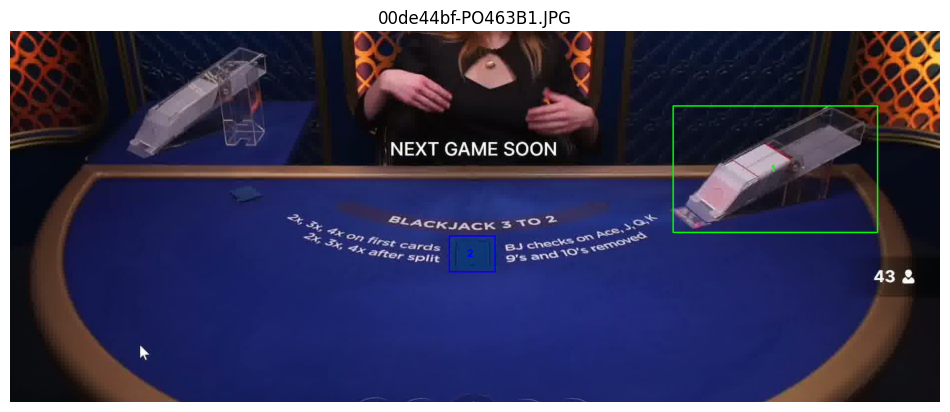

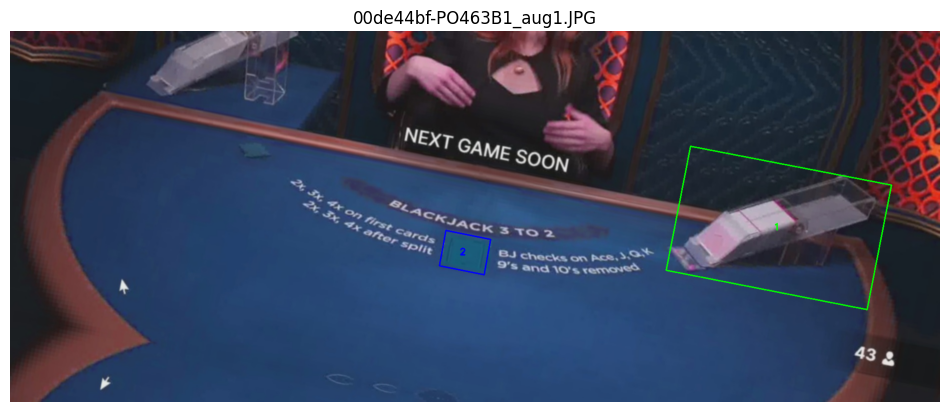

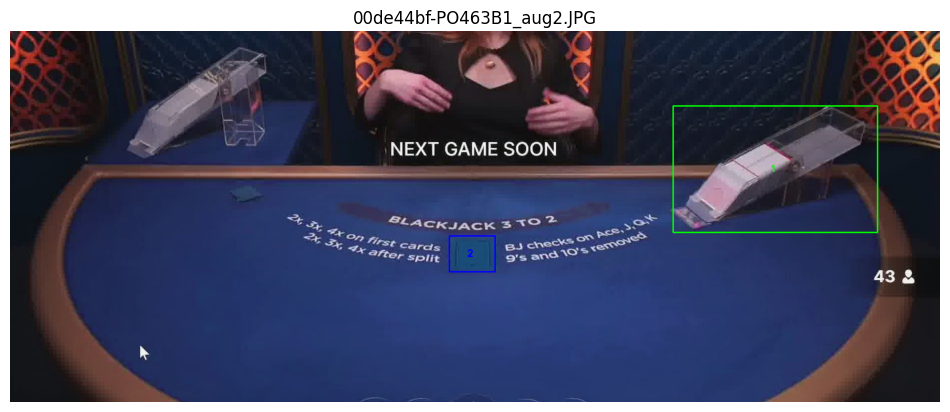

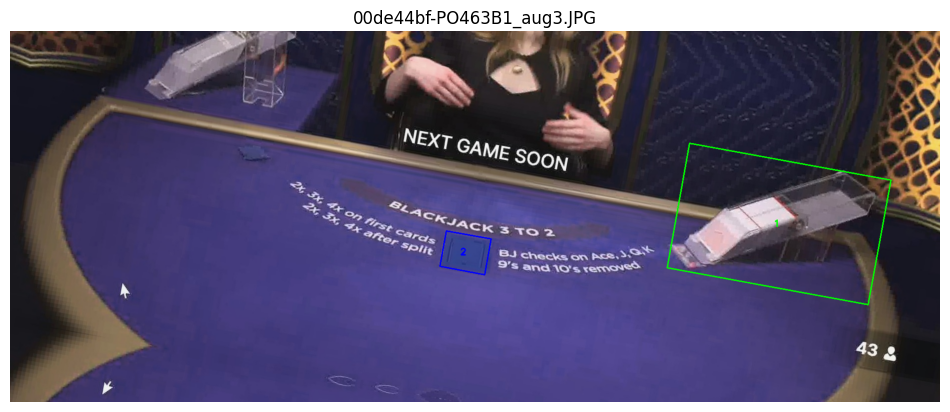

In [19]:
# Visualize training samples
train_images_dir = OUTPUT_DATASET / "images" / "train"
train_labels_dir = OUTPUT_DATASET / "labels" / "train"

images = YOLO_HELPERS.list_images(train_images_dir)
print(f"Showing 4 samples from {len(images)} training images:\n")

for img_path in images[:4]:
    label_path = train_labels_dir / f"{img_path.stem}.txt"
    visualize_obb_sample(img_path, label_path)

## 11) Training

### CLI command 

In [20]:
cmd = processor.get_training_command()

print(f"{'='*60}")
print("TRAINING COMMAND")
print(f"{'='*60}")
print(f"\n{cmd}\n")
print(f"{'='*60}")

TRAINING COMMAND

yolo train cfg="C:\Users\floot\Florian's Laptop\ESILV\CV and Deep Learning\ESILV_A5_Computer_Vision\dataset_creation\datasets\label_studio_export_obb_dataset_augmented\train_cfg.yaml"

